<a href="https://colab.research.google.com/github/devashree1923/fake-news-datasets/blob/master/FAKE_NEWS_DETECTION_PAPER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import re
import tensorflow
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

In [2]:
## This is the test Data
test_data = pd.read_csv('/content/sample_data/test.csv')
## Import dataset
df = pd.read_csv('/content/sample_data/train.csv')

In [3]:
test_data.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [4]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
## Check the Null Values 
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
# Drop Null values
df = df.dropna()

In [7]:
# Now count the Unique values to check the data is balanced or not
count = np.unique(df['label'], return_counts=True)
count

(array([0, 1]), array([10361,  7924]))

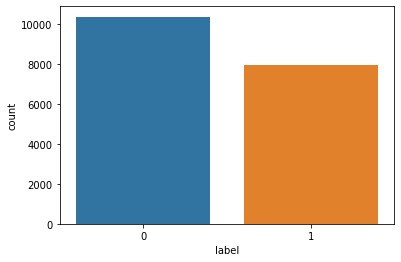

In [8]:
import seaborn as sns
sns.countplot(x='label', data = df)

In [9]:
# Dependent Features
Y = df['label']

# Independent Features
X = df.drop('label', axis=1)

In [10]:
# make the copy of Dependent Featues and reset the index because we drop the nan values due to this 
# the index is disturb
messages = X.copy()
# messages.reset_index(inplace=True)

In [11]:
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [12]:
messages.reset_index(inplace=True)

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [15]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords]
    review = ' '.join(review)
    corpus.append(review)

In [16]:
corpus[1]


'flynn hillari clinton big woman campu breitbart'

In [17]:
voc_size = 5000
onehot_repre = [one_hot(words, voc_size) for words in corpus]
onehot_repre[0]

[2449, 7, 4230, 3794, 1262, 1421, 2451, 3928, 2312, 4297]

In [18]:
sent_length = 20
embedded_docs = pad_sequences(onehot_repre, padding='pre', maxlen=sent_length)
print(embedded_docs[0])

[   0    0    0    0    0    0    0    0    0    0 2449    7 4230 3794
 1262 1421 2451 3928 2312 4297]


In [19]:
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
x_final = np.array(embedded_docs)
y_final = np.array(Y)

In [21]:
x_final.shape, y_final.shape

((18285, 20), (18285,))

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.33, random_state=42)

In [23]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
192/192 [==============================] - 12s 10ms/step - loss: 0.3262 - accuracy: 0.8474 - val_loss: 0.2082 - val_accuracy: 0.9173
Epoch 2/10
192/192 [==============================] - 1s 7ms/step - loss: 0.1381 - accuracy: 0.9448 - val_loss: 0.1900 - val_accuracy: 0.9221
Epoch 3/10
192/192 [==============================] - 1s 7ms/step - loss: 0.0964 - accuracy: 0.9640 - val_loss: 0.2183 - val_accuracy: 0.9160
Epoch 4/10
192/192 [==============================] - 1s 7ms/step - loss: 0.0674 - accuracy: 0.9752 - val_loss: 0.2584 - val_accuracy: 0.9158
Epoch 5/10
192/192 [==============================] - 1s 7ms/step - loss: 0.0454 - accuracy: 0.9849 - val_loss: 0.2943 - val_accuracy: 0.9168
Epoch 6/10
192/192 [==============================] - 1s 7ms/step - loss: 0.0298 - accuracy: 0.9900 - val_loss: 0.3731 - val_accuracy: 0.9145
Epoch 7/10
192/192 [==============================] - 1s 8ms/step - loss: 0.0178 - accuracy: 0.9944 - val_loss: 0.4828 - val_accuracy: 0.9095
Epoc

In [24]:
classes_x = (model.predict(X_test) > 0.5).astype("int32")

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, classes_x)

array([[3150,  269],
       [ 307, 2309]])

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,classes_x)

0.9045567522783762